In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

div2k_data = tfds.image.Div2k(config="bicubic_x4")
div2k_data.download_and_prepare()

AUTOTUNE = tf.data.AUTOTUNE

In [3]:
train = div2k_data.as_dataset(split="train", as_supervised=True)
train_cache = train.cache()

val = div2k_data.as_dataset(split="validation", as_supervised=True)
val_cache = val.cache()


In [4]:
def flip_left_right(lowres_img, highres_img):
	rn = tf.random.uniform(shape=(), maxval=1)
	# If rn is less than 0.5 it returns original lowres_img and highres_img
	# If rn is greater than 0.5 it returns flipped image
	return tf.cond(
			rn < 0.5,
			lambda: (lowres_img, highres_img),
			lambda: (
					tf.image.flip_left_right(lowres_img),
					tf.image.flip_left_right(highres_img),
			),
	)

In [5]:
from tensorflow.image import rot90

def random_rotate(lowres_img, highres_img):
	rn = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
	# Here rn signifies number of times the image(s) are rotated by 90 degrees
	return rot90(lowres_img, rn), rot90(highres_img, rn)


In [6]:
def random_crop(lowres_img, highres_img, hr_crop_size=96, scale=4):
	lowres_crop_size = hr_crop_size // scale  # 96//4=24
	lowres_img_shape = tf.shape(lowres_img)[:2]  # (height,width)

	lowres_width = tf.random.uniform(
			shape=(), maxval=lowres_img_shape[1] - lowres_crop_size + 1, dtype=tf.int32
	)
	lowres_height = tf.random.uniform(
			shape=(), maxval=lowres_img_shape[0] - lowres_crop_size + 1, dtype=tf.int32
	)

	highres_width = lowres_width * scale
	highres_height = lowres_height * scale

	lowres_img_cropped = lowres_img[
			lowres_height : lowres_height + lowres_crop_size,
			lowres_width : lowres_width + lowres_crop_size,
	]  # 24x24
	highres_img_cropped = highres_img[
			highres_height : highres_height + hr_crop_size,
			highres_width : highres_width + hr_crop_size,
	]  # 96x96

	return lowres_img_cropped, highres_img_cropped


In [7]:
def dataset_object(dataset_cache, batch_size, training=True):
	ds = dataset_cache
	ds = ds.map(
			lambda lowres, highres: random_crop(lowres, highres, scale=4),
			num_parallel_calls=AUTOTUNE,
	)

	if training:
			ds = ds.map(random_rotate, num_parallel_calls=AUTOTUNE)
			ds = ds.map(flip_left_right, num_parallel_calls=AUTOTUNE)

	ds = ds.batch(batch_size)

	if training:
			ds = ds.repeat()

	ds = ds.prefetch(buffer_size=AUTOTUNE)
	return ds

In [8]:
batch_size = 64

train_ds = dataset_object(train_cache, batch_size, training=True)
val_ds = dataset_object(val_cache, batch_size, training=False)

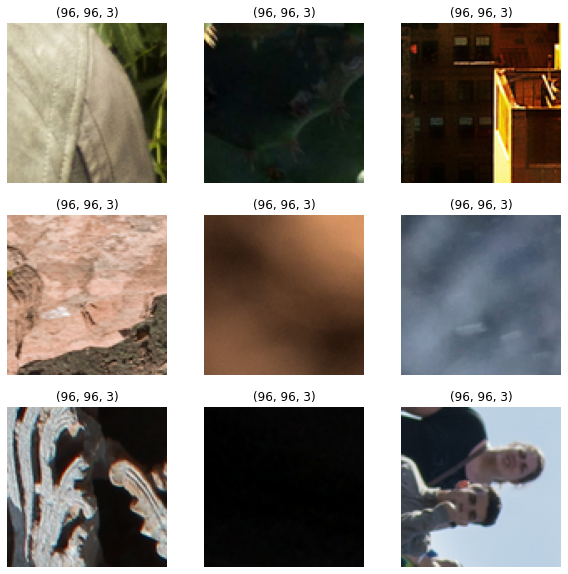

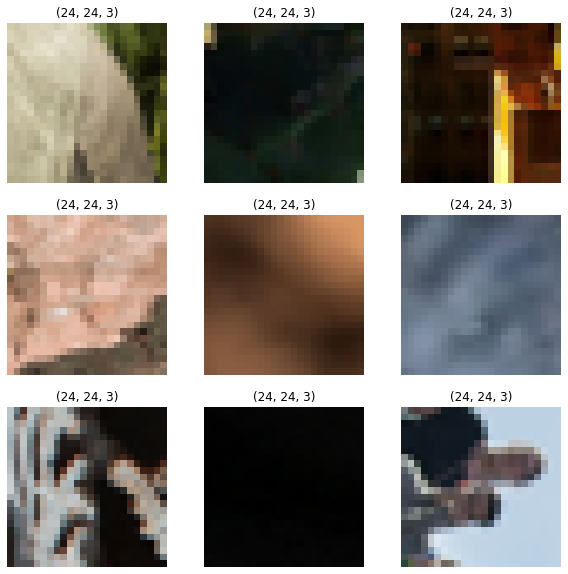

In [9]:
lowres, highres = next(iter(train_ds))

# Hight Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(highres[i].numpy().astype("uint8"))
    plt.title(highres[i].shape)
    plt.axis("off")

# Low Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(lowres[i].numpy().astype("uint8"))
    plt.title(lowres[i].shape)
    plt.axis("off")


def PSNR(super_resolution, high_resolution):
    """Compute the peak signal-to-noise ratio, measures quality of image."""
    # Max value of pixel is 255
    psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=255)[0]
    return psnr_value


In [10]:
from keras.layers import Conv2D, Add 
from tensorflow.nn import depth_to_space

def ResBlock(inputs):
    x = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(inputs)
    x = Conv2D(filters=64, kernel_size=(3,3), padding="same")(x)
    x = Add()([inputs, x])
    return x


# Upsampling Block
def Upsampling(inputs, factor=2, **kwargs):
    x = Conv2D(filters=64 * (factor ** 2), kernel_size=(3,3), padding="same", **kwargs)(inputs)
    x = depth_to_space(x, block_size=factor)
    x = Conv2D(filters=64 * (factor ** 2), kernel_size=(3,3), padding="same", **kwargs)(x)
    x = depth_to_space(x, block_size=factor)
    return x

In [11]:
class EDSRModel(tf.keras.Model):
  def train_step(self, data):
    X, y = data
    with tf.GradientTape() as tape:
      y_pred = self(X, training=True)  
      loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    # Update weights
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))
    self.compiled_metrics.update_state(y, y_pred)
    return {m.name: m.result() for m in self.metrics}

  def predict_step(self, X):
    X = tf.cast(tf.expand_dims(X, axis=0), tf.float32)
    super_resolution_img = self(X, training=False)
    # Clips the tensor from min(0) to max(255)
    super_resolution_img = tf.clip_by_value(super_resolution_img, 0, 255)
    # Rounds the values of a tensor to the nearest integer
    super_resolution_img = tf.round(super_resolution_img)
    super_resolution_img = tf.squeeze(tf.cast(super_resolution_img, tf.uint8), 
                                      axis=0)
    return super_resolution_img


In [12]:
from keras.layers import Input, Rescaling

def make_model(num_filters, num_of_residual_blocks):
  input_layer = Input(shape=(None, None, 3))

  # Scaling Pixel Values
  x = Rescaling(scale=1.0 / 255)(input_layer)
  x = x_new = Conv2D(filters=num_filters, kernel_size=(3,3), padding="same")(x)

  # 16 residual blocks
  for _ in range(num_of_residual_blocks):
    x_new = ResBlock(x_new)

  x_new = Conv2D(filters=num_filters, kernel_size=(3,3), padding="same")(x_new)
  x = Add()([x, x_new])

  x = Upsampling(x)
  x = Conv2D(filters=3, kernel_size=(3,3), padding="same")(x)

  output_layer = Rescaling(scale=255)(x)
  return EDSRModel(inputs=input_layer, outputs=output_layer)

In [13]:
model = make_model(num_filters=64, num_of_residual_blocks=16)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay

optim_edsr = Adam(learning_rate=PiecewiseConstantDecay(boundaries=[5000], 
                                                       values=[1e-4, 5e-5]))
model.compile(optimizer=optim_edsr, loss="mae", metrics=[PSNR])
model.fit(train_ds, epochs=100, steps_per_epoch=200, validation_data=val_ds)

Epoch 1/100
200/200 [==============================] - 94s 355ms/step - loss: 25.6601 - PSNR: 20.6926 - val_loss: 12.6581 - val_PSNR: 24.6474
Epoch 2/100
200/200 [==============================] - 23s 116ms/step - loss: 11.6922 - PSNR: 26.1488 - val_loss: 10.1942 - val_PSNR: 22.6002
Epoch 3/100
200/200 [==============================] - 23s 117ms/step - loss: 10.2244 - PSNR: 27.5107 - val_loss: 10.2684 - val_PSNR: 22.5517
Epoch 4/100
200/200 [==============================] - 24s 119ms/step - loss: 9.3611 - PSNR: 28.7804 - val_loss: 9.4659 - val_PSNR: 29.7258
Epoch 5/100
200/200 [==============================] - 24s 122ms/step - loss: 8.9252 - PSNR: 29.0526 - val_loss: 8.6135 - val_PSNR: 28.9262
Epoch 6/100
200/200 [==============================] - 24s 121ms/step - loss: 8.6257 - PSNR: 29.8788 - val_loss: 9.3552 - val_PSNR: 25.5345
Epoch 7/100
200/200 [==============================] - 24s 119ms/step - loss: 8.3969 - PSNR: 30.3354 - val_loss: 8.5078 - val_PSNR: 28.6089
Epoch 8/100
20

In [ ]:
def plot_results(lowres, preds):
  plt.figure(figsize=(24, 14))
  plt.subplot(132), plt.imshow(lowres), plt.title("Low resolution")
  plt.subplot(133), plt.imshow(preds), plt.title("Prediction")
  plt.show()


for lowres, highres in val.take(10):
  lowres = tf.image.random_crop(lowres, (150, 150, 3))
  preds = model.predict_step(lowres)
  plot_results(lowres, preds)